In [1]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image

import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data_dir = r'D:\GH\DeepLearning\dataset\flowers'
batch_size = 16
img_height = 112
img_width = 112

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


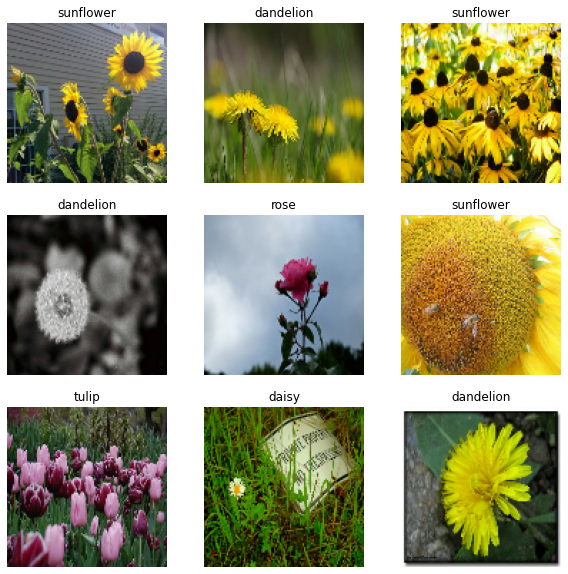

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width)

In [7]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# GoogleNet

In [8]:
def Stem(input):
    x=layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(input)
    x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x=layers.LayerNormalization()(x)
    x=layers.Conv2D(filters=192,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.LayerNormalization()(x)
    x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)    
    return x


def Inception_Block(x,f1,f2,f3,f4,f5,f6):

    x1=layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
          
    x2=layers.Conv2D(filters=f2,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x2=layers.Conv2D(filters=f3,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(x2)

    x3=layers.Conv2D(filters=f4 ,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x3=layers.Conv2D(filters=f5,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')(x3)
       
    x4=layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    x4=layers.Conv2D(filters=f6,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x4)
    
    return tf.concat([x1,x2,x3,x4],axis=3)

def AUX1(input):
    ax=layers.AveragePooling2D(pool_size=(1,1),strides=(1,1))(input)
    ax=layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(ax)
    ax=layers.Flatten()(ax)
    ax=layers.Dense(units=1024,activation='relu')(ax)
    ax=layers.Dropout(0.7)(ax)
    ax=layers.Dense(units=10,activation='softmax',name='ax1')(ax)
    return ax

def AUX2(input):
    ax=layers.AveragePooling2D(pool_size=(1,1),strides=(1,1))(input)
    ax=layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(ax)
    ax=layers.Flatten()(ax)
    ax=layers.Dense(units=1024,activation='relu')(ax)
    ax=layers.Dropout(0.7)(ax)
    ax=layers.Dense(units=10,activation='softmax',name='ax2')(ax)
    return ax


def Classifier(input):
    # fc=layers.AveragePooling2D(pool_size=(7,7),strides=(1,1))(input)    # if input size is (224, 224, None)
    fc=layers.AveragePooling2D(pool_size=(4,4),strides=(1,1))(input)    # if input size is (112, 112, None)
    fc=layers.Flatten()(fc)
    fc=layers.Dense(units=5,activation='softmax',name='output')(fc)    
    return fc

In [9]:
inputs=Input(shape=(112,112,3))
x=Stem(inputs)
x=Inception_Block(x,256,256,256,256,256,256)
x=Inception_Block(x,480,480,480,480,480,480)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=Inception_Block(x,512,512,512,512,512,512)

ax1=AUX1(x)
x=Inception_Block(x,512,512,512,512,512,512)
x=Inception_Block(x,512,512,512,512,512,512)
x=Inception_Block(x,528,528,528,528,528,528)

ax2=AUX2(x)
x=Inception_Block(x,832,832,832,832,832,832)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x=Inception_Block(x,832,832,832,832,832,832)
x=Inception_Block(x,1024,1024,1024,1024,1024,1024)
output=Classifier(x)
   
GoogleNet = tf.keras.models.Model(inputs,[output,ax1,ax2],name = 'GoogleNet')

In [10]:
lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 30000, 0.93, staircase=False, name=None)

In [11]:
GoogleNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard

model_checkpoint_best_path=r'./models/VGG_16/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path, monitor='val_output_accuracy', save_best_only=True, save_weights_only=True, save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_output_accuracy', patience=10, min_delta=1e-4)

log_dir=r'./models/log_dir/'
tensorboard_callback=TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
GoogleNet.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 28, 28, 64)  128         ['max_pooling2d[0][0]']  

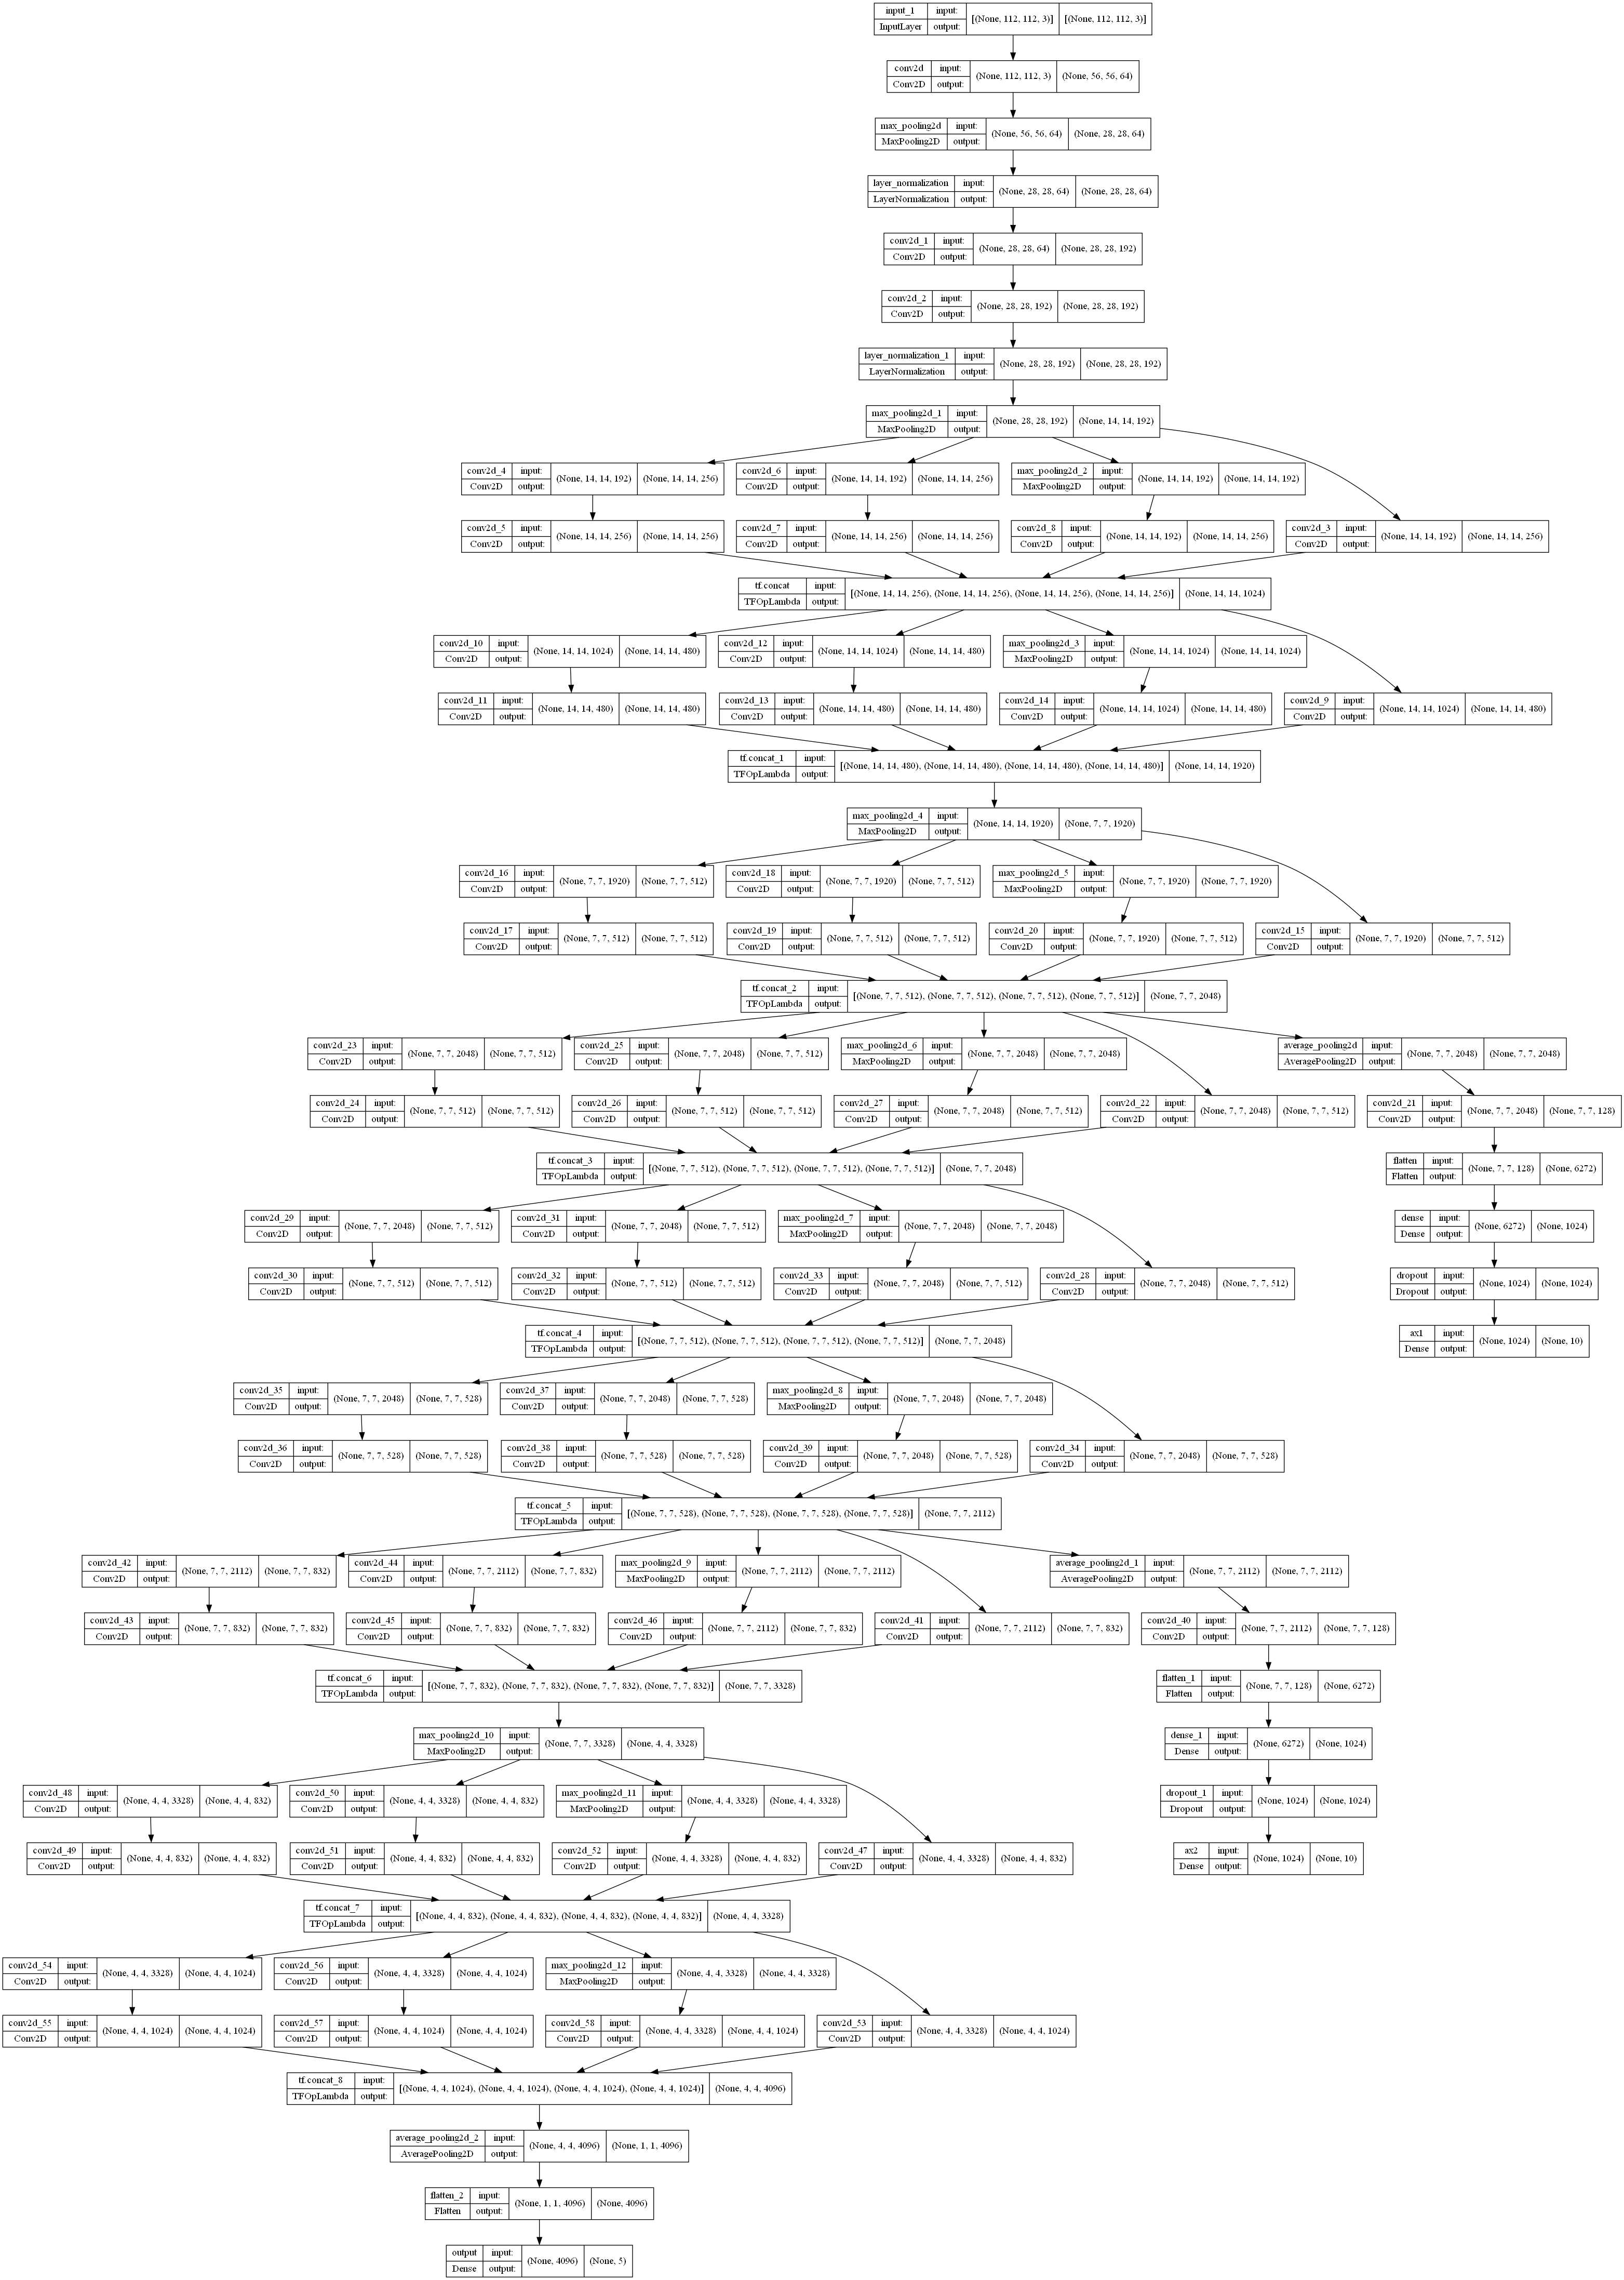

In [14]:
plot_model(GoogleNet,to_file='GoogleNet.png',show_shapes=True)

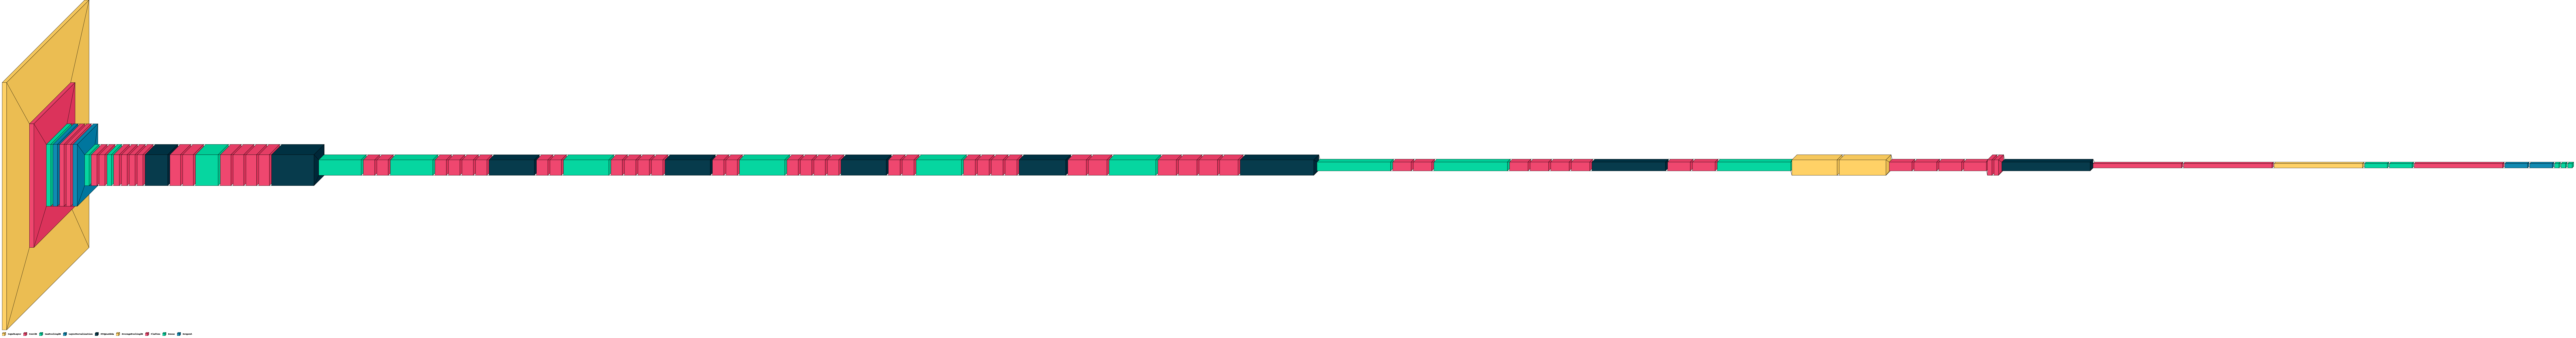

In [15]:
import visualkeras
visualkeras.layered_view(GoogleNet, scale_xy=10, legend=True)

In [16]:
hist = GoogleNet.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[model_checkpoint_best, early_stopping, tensorboard_callback], verbose=1)

Epoch 1/3
217/217 [==============================] - 103s 423ms/step - loss: 48.6778 - output_loss: 43.9081 - ax1_loss: 1.8609 - ax2_loss: 2.9088 - output_accuracy: 0.2408 - ax1_accuracy: 0.2220 - ax2_accuracy: 0.2220 - val_loss: 4.8145 - val_output_loss: 1.5989 - val_ax1_loss: 1.6062 - val_ax2_loss: 1.6093 - val_output_accuracy: 0.2326 - val_ax1_accuracy: 0.2326 - val_ax2_accuracy: 0.2326
Epoch 2/3
217/217 [==============================] - 71s 326ms/step - loss: 4.8588 - output_loss: 1.6015 - ax1_loss: 1.6337 - ax2_loss: 1.6236 - output_accuracy: 0.2460 - ax1_accuracy: 0.2090 - ax2_accuracy: 0.2235 - val_loss: 4.8052 - val_output_loss: 1.5975 - val_ax1_loss: 1.6028 - val_ax2_loss: 1.6049 - val_output_accuracy: 0.2326 - val_ax1_accuracy: 0.2326 - val_ax2_accuracy: 0.2326
Epoch 3/3
217/217 [==============================] - 71s 327ms/step - loss: 4.8325 - output_loss: 1.6005 - ax1_loss: 1.6119 - ax2_loss: 1.6201 - output_accuracy: 0.2460 - ax1_accuracy: 0.2342 - ax2_accuracy: 0.2148 - 

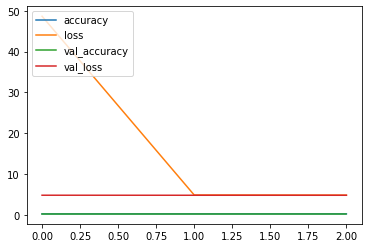

In [24]:
plt.plot(hist.history['output_accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_output_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [23]:
loss, _, __, ___, acc, _1, _2 = GoogleNet.evaluate(val_ds, verbose=1)
print(loss, acc)

54/54 [==============================] - 4s 73ms/step - loss: 4.8028 - output_loss: 1.5970 - ax1_loss: 1.6026 - ax2_loss: 1.6032 - output_accuracy: 0.2326 - ax1_accuracy: 0.2326 - ax2_accuracy: 0.2326
4.8028411865234375 0.2326388955116272


In [25]:
GoogleNet.save("models/GoogleNet_001.h5")